In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import shap
import joblib
from sklearn.metrics import make_scorer

/home/chico/Projetos/P5/PE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Dados/AmesHousing.csv")
TARGET = "SalePrice"

In [3]:
y = df[TARGET]
X = df.drop(columns=[TARGET])
print("Tamanho do dataset:", df.shape)
print("\nTipos de variáveis:\n", X.dtypes.value_counts())
#print("\nEstatísticas das variáveis numéricas:\n", X.describe().T)

Tamanho do dataset: (2930, 82)

Tipos de variáveis:
 object     43
int64      27
float64    11
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [5]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numéricas:", len(num_cols), "Categoricas:", len(cat_cols))

Numéricas: 38 Categoricas: 43


Pré-processamento: pipelines

In [6]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

Função para avaliação


In [7]:
def evaluate_model(model, name):
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")
    return {'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'pipeline': pipe}

In [8]:
results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(Ridge(random_state=42), "Ridge"))
results.append(evaluate_model(Lasso(random_state=42, max_iter=10000), "Lasso"))
results.append(evaluate_model(RandomForestRegressor(random_state=42, n_jobs=-1), "Random Forest"))
results.append(evaluate_model(xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0), "XGBoost"))

baseline_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R2']]
print("\nDesempenho inicial:\n", baseline_df.sort_values('RMSE'))

Linear Regression -> RMSE: 848754906.356 | MAE: 15711.509 | R²: 0.894
Ridge -> RMSE: 827039588.997 | MAE: 16158.600 | R²: 0.897
Lasso -> RMSE: 841465188.969 | MAE: 15674.429 | R²: 0.895
Random Forest -> RMSE: 711477915.206 | MAE: 15906.563 | R²: 0.911
XGBoost -> RMSE: 685711360.000 | MAE: 15534.977 | R²: 0.914

Desempenho inicial:
               Modelo          RMSE           MAE        R2
4            XGBoost  6.857114e+08  15534.976562  0.914474
3      Random Forest  7.114779e+08  15906.562662  0.911260
1              Ridge  8.270396e+08  16158.600300  0.896846
2              Lasso  8.414652e+08  15674.428712  0.895047
0  Linear Regression  8.487549e+08  15711.508915  0.894138


Tuning com OPTUNA – Random Forest e XGBoost

RandomForestRegressor

In [9]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [10]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective_rf, n_trials=40)
print("Melhores parâmetros RF:", study_rf.best_params)

[I 2025-11-02 17:09:51,078] A new study created in memory with name: rf_tuning
[I 2025-11-02 17:09:59,115] Trial 0 finished with value: 885395021.2424078 and parameters: {'n_estimators': 355, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 885395021.2424078.
[I 2025-11-02 17:10:26,062] Trial 1 finished with value: 744858323.3574212 and parameters: {'n_estimators': 448, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 744858323.3574212.
[I 2025-11-02 17:10:35,882] Trial 2 finished with value: 774881163.2134285 and parameters: {'n_estimators': 192, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value: 744858323.3574212.
[I 2025-11-02 17:10:53,341] Trial 3 finished with value: 743549609.3248992 and parameters: {'n_estimators': 270, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 743549609.3248992.
[I 2025-11-02 17:10:5

Melhores parâmetros RF: {'n_estimators': 578, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2}


In [11]:
best_rf = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1, **study_rf.best_params))
])
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

XGBoost 

In [12]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)
    }
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [13]:
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_tuning')
study_xgb.optimize(objective_xgb, n_trials=40)
print("Melhores parâmetros XGB:", study_xgb.best_params)

[I 2025-11-02 17:33:08,573] A new study created in memory with name: xgb_tuning
[I 2025-11-02 17:33:26,403] Trial 0 finished with value: 703418912.0 and parameters: {'n_estimators': 331, 'max_depth': 14, 'learning_rate': 0.14117509779420226, 'subsample': 0.8635157041467069, 'colsample_bytree': 0.760264579836331, 'min_child_weight': 9, 'gamma': 4.426269776708645, 'reg_lambda': 0.012829259286549146, 'reg_alpha': 3.861023735361414}. Best is trial 0 with value: 703418912.0.
[I 2025-11-02 17:33:36,189] Trial 1 finished with value: 715486355.2 and parameters: {'n_estimators': 606, 'max_depth': 4, 'learning_rate': 0.2106498205535087, 'subsample': 0.5345434056738017, 'colsample_bytree': 0.816274352113505, 'min_child_weight': 6, 'gamma': 2.3666768190694465, 'reg_lambda': 0.03649558645517742, 'reg_alpha': 0.49167918434668695}. Best is trial 0 with value: 703418912.0.
[I 2025-11-02 17:33:57,276] Trial 2 finished with value: 609582105.6 and parameters: {'n_estimators': 675, 'max_depth': 10, 'learn

Melhores parâmetros XGB: {'n_estimators': 700, 'max_depth': 12, 'learning_rate': 0.010820409822723727, 'subsample': 0.5052536074271574, 'colsample_bytree': 0.5793767245432931, 'min_child_weight': 9, 'gamma': 3.0647886004032188, 'reg_lambda': 0.02803663087697915, 'reg_alpha': 9.676454247738562}


In [14]:
best_xgb = Pipeline([
    ('preproc', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **study_xgb.best_params))
])
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

In [15]:
final_df = pd.concat([
    baseline_df,
    pd.DataFrame([
        {'Modelo': 'RandomForest (Optuna)', 'RMSE': rf_rmse, 'MAE': rf_mae, 'R2': rf_r2},
        {'Modelo': 'XGBoost (Optuna)', 'RMSE': xgb_rmse, 'MAE': xgb_mae, 'R2': xgb_r2}
    ])
], ignore_index=True).sort_values('RMSE')
print("\nResultados finais comparativos:\n", final_df)


Resultados finais comparativos:
                   Modelo          RMSE           MAE        R2
6       XGBoost (Optuna)  6.060068e+08  13766.828125  0.924415
4                XGBoost  6.857114e+08  15534.976562  0.914474
3          Random Forest  7.114779e+08  15906.562662  0.911260
5  RandomForest (Optuna)  7.220496e+08  15831.617348  0.909941
1                  Ridge  8.270396e+08  16158.600300  0.896846
2                  Lasso  8.414652e+08  15674.428712  0.895047
0      Linear Regression  8.487549e+08  15711.508915  0.894138


Visualização e comparação

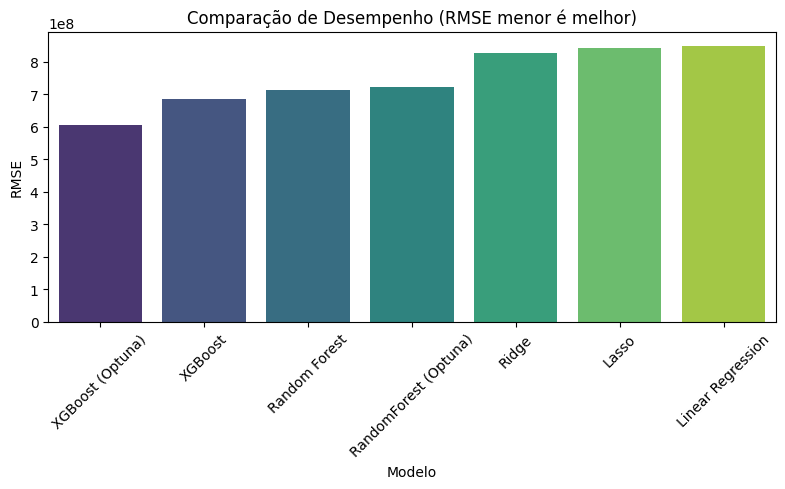

In [49]:
plt.figure(figsize=(8, 5))
sns.barplot(data=final_df, x='Modelo', y='RMSE', palette='viridis', hue='Modelo')
plt.xticks(rotation=45)
plt.title('Comparação de Desempenho (RMSE menor é melhor)')
plt.tight_layout()
plt.show()


Salvando artefatos

In [53]:
joblib.dump(best_rf, 'Resultados/best_random_forest_optuna.joblib')
joblib.dump(best_xgb, 'Resultados/best_xgboost_optuna.joblib')
final_df.to_csv('comparacao_modelos.csv', index=False)

print("\nModelos e resultados salvos com sucesso!")


Modelos e resultados salvos com sucesso!
